<a href="https://colab.research.google.com/github/bhallimk/Capstone_Project_2024/blob/main/Sentiment_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, json, gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from joblib import dump

import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv("/content/drive/MyDrive/Amazon_Smartphones_Reviews.csv")

In [4]:
df.head(10)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
5,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,1,I already had a phone with problems... I know ...,1.0
6,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,The charging port was loose. I got that solder...,0.0
7,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,"Phone looks good but wouldn't stay charged, ha...",0.0
8,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I originally was using the Samsung S2 Galaxy f...,0.0
9,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,3,It's battery life is great. It's very responsi...,0.0


In [5]:
df.shape

(413840, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413778 non-null  object 
 5   Review Votes  401544 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


In [7]:
df.isnull().sum()

Product Name        0
Brand Name      65171
Price            5933
Rating              0
Reviews            62
Review Votes    12296
dtype: int64

In [8]:
# drop any rows w/ missing values
df = df.dropna()
# discover the actual counts
df.Rating.value_counts()

sample_size = 50000
df_equal_overall = pd.DataFrame()
for i in df.Rating.unique():
    subset = df[df.Rating == i]
    if len(subset) >= sample_size:
        X = subset.sample(sample_size)
    else:
        X = subset.sample(sample_size, replace=True)
    df_equal_overall = df_equal_overall.append(X)


<ipython-input-8-2c653ce71235>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_equal_overall = df_equal_overall.append(X)
<ipython-input-8-2c653ce71235>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_equal_overall = df_equal_overall.append(X)
<ipython-input-8-2c653ce71235>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_equal_overall = df_equal_overall.append(X)
<ipython-input-8-2c653ce71235>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_equal_overall = df_equal_overall.append(X)
<ipython-input-8-2c653ce71235>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

In [9]:
df.shape

(334335, 6)

In [10]:
df['Length'] = df['Reviews'].apply(len)

In [11]:
# Filter the Samsung Reviews from the dataset
samsung_reviews = df[df['Brand Name'] == 'Samsung']

# Print the filtered DataFrame
samsung_reviews

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Length
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,374
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,214
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,12
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,76
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,223
...,...,...,...,...,...,...,...
413835,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,another great deal great price,0.0,30
413836,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,Ok,0.0,2
413837,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,Passes every drop test onto porcelain tile!,0.0,43
413838,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,I returned it because it did not meet my needs...,0.0,92


In [12]:
print(f"Review Votes : \n{df['Review Votes'].value_counts()}")

Review Votes : 
0.0      233064
1.0       47265
2.0       19652
3.0        9634
4.0        5727
          ...  
100.0         1
264.0         1
186.0         1
142.0         1
335.0         1
Name: Review Votes, Length: 234, dtype: int64


In [13]:
df['Brand Name'].unique()

array(['Samsung', 'Nokia', 'HTM', 'Jethro', 'e passion',
       'Cedar Tree Technologies', 'Indigi', 'Phone Baby', 'OtterBox',
       'Lenovo', 'Huawei', 'JUNING', 'Elephone', 'Plum', 'VKworld',
       'NOKIA', 'Ulefone', 'Jiuhe', 'inDigi', 'Acer', 'Aeku', 'Alcatel',
       'TCL Mobile', 'LG', 'amar', 'Amazon', 'Odysseus', 'Digital SNITCH',
       'star', 'Android', 'Yezz', 'Yezz Wireless Ltd.', 'Apple',
       'Apple Computer', 'Certified Refurbished',
       'Amazon.com, LLC *** KEEP PORules ACTIVE ***', 'apple',
       'ARGOM TECH', 'Asus', 'ASUS', 'ASUS Computers', 'asus',
       'BlackBerry', 'Motorola', 'Palm', 'Pantech', 'ZTE', 'ATT', 'Atoah',
       'BlackBerry Storm 9530 Smartphone Unlocked GSM Wireless Handheld Device w/Camera Bluetooth 3.25" Touchscreen LCD',
       'WorryFree Gadgets', 'worryfree', 'iDROID USA', 'Blackberry (Rim)',
       'Research In Motion', 'BLACKBERRY', 'Black Berry', 'Blackberry',
       'blackberry', 'RIM', 'Research in Motion', 'Blackberrry', 'Storm'

In [14]:
# Filter the Samsung Reviews from the dataset
apple_reviews = df[df['Brand Name'] == 'Apple']

# Print the filtered DataFrame
apple_reviews


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Length
3081,Apple - Iphone 5c A1532 Verizon 16 GB Cell Pho...,Apple,33.0,5,Was a gift for my husband and he loves it. Rep...,5.0,260
3082,Apple - Iphone 5c A1532 Verizon 16 GB Cell Pho...,Apple,33.0,5,"Great price, extremely fast shipping works as ...",1.0,57
3083,Apple - Iphone 5c A1532 Verizon 16 GB Cell Pho...,Apple,33.0,4,Moving from Android to Apple...my kids have th...,1.0,337
3084,Apple - Iphone 5c A1532 Verizon 16 GB Cell Pho...,Apple,33.0,4,It is compatible with Verizon. Not pink but PE...,0.0,174
3085,Apple - Iphone 5c A1532 Verizon 16 GB Cell Pho...,Apple,33.0,5,I love this phone! Thank you so much.,1.0,37
...,...,...,...,...,...,...,...
410273,Virgin Mobile iPhone 5 Black,Apple,289.0,5,It came as a new item. No scratches. Works per...,1.0,51
410274,Virgin Mobile iPhone 5 Black,Apple,289.0,1,"In fact, this phone could not be activated by ...",1.0,306
410275,Virgin Mobile iPhone 5 Black,Apple,289.0,5,Nice phone.,0.0,11
410276,Virgin Mobile iPhone 5 Black,Apple,289.0,2,Why Is This iPhone Locked ?? And Only Came Wit...,4.0,152


In [15]:
# Filter the Samsung Reviews from the dataset
moto_reviews = df[df['Brand Name'] == 'Motorola']

# Print the filtered DataFrame
moto_reviews

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Length
83002,AT&T Motorola RAZR V3 No Contract Quad Band GS...,Motorola,26.99,1,Not good,0.0,8
83003,AT&T Motorola RAZR V3 No Contract Quad Band GS...,Motorola,26.99,1,junk did not work got a refund,0.0,30
83004,AT&T Motorola RAZR V3 No Contract Quad Band GS...,Motorola,26.99,3,"I love the looks of it but,it has no S.D.slot....",0.0,127
83005,AT&T Motorola RAZR V3 No Contract Quad Band GS...,Motorola,26.99,4,Got phone it had no scratches but can't find w...,0.0,191
83006,AT&T Motorola RAZR V3 No Contract Quad Band GS...,Motorola,26.99,4,Works great,0.0,11
...,...,...,...,...,...,...,...
408245,Verizon or PagePlus Motorola W385 Great Condit...,Motorola,11.11,5,Gets such good reception!,0.0,25
408246,Verizon or PagePlus Motorola W385 Great Condit...,Motorola,11.11,5,This phone is the best. It cannot die. CAN NOT...,0.0,118
408247,Verizon or PagePlus Motorola W385 Great Condit...,Motorola,11.11,5,These guys really know what the are doing.. Th...,0.0,136
408248,Verizon or PagePlus Motorola W385 Great Condit...,Motorola,11.11,5,I bought this older phone for someone who like...,0.0,201


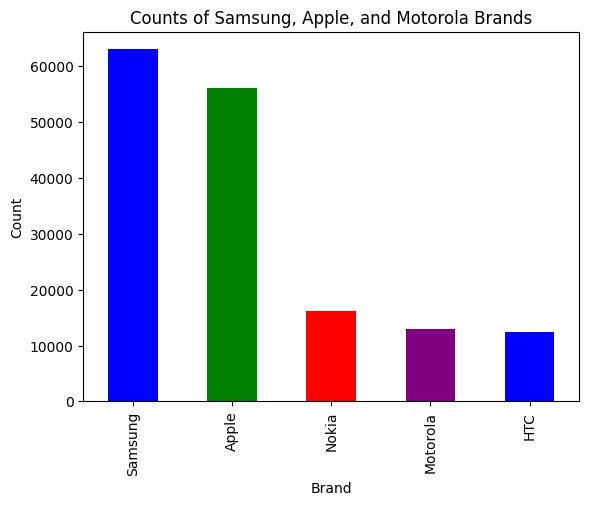

In [16]:
brand_column = 'Brand Name'

# Filter rows for Samsung, Apple, and Motorola brands
selected_brands = df[df[brand_column].isin(['Samsung', 'Apple', 'HTC', 'Motorola', 'Nokia'])]

# Create a bar plot
brand_counts = selected_brands[brand_column].value_counts()
brand_counts.plot(kind='bar', color=['blue', 'green', 'red', 'purple'])

# Customize the plot
plt.title('Counts of Samsung, Apple, and Motorola Brands')
plt.xlabel('Brand')
plt.ylabel('Count')

# Show the plot
plt.show()

In [17]:
print(f"Random Review : {df.iloc[400]['Reviews']}")
print(f"Length of  Review : {len(df.iloc[400]['Reviews'])}")
print(f"Length Column Value : {df.iloc[400]['Length']}")


Random Review : Not happy with this phone. Not able to get but 1 gh on this phone. I have been with T-Mobile for 5 years and been very satisfied with their service. Because this phone is foreign, neither TMobile or ATT were able to get a faster internet. It is very slow and very often says it cant open the page and says retry. Also, the screen of the phone began cracking within a week of having it. This phone is only good for making phone calls and texting.
Length of  Review : 445
Length Column Value : 445


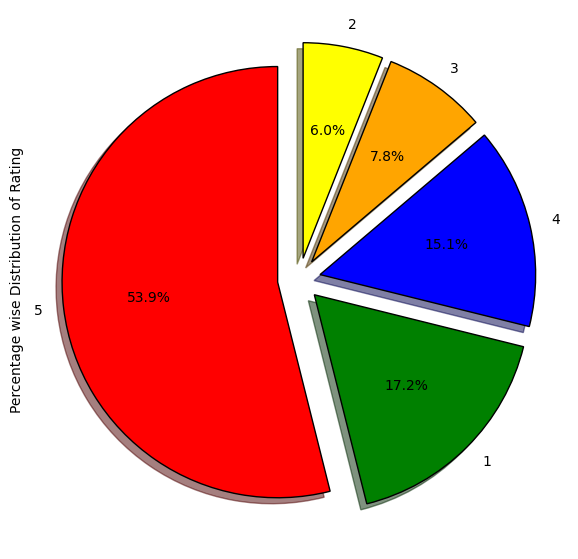

In [18]:
fig = plt.figure(figsize=(7, 7))

colors = ('red', 'green', 'blue', 'orange', 'yellow')

wp = {'linewidth':1, "edgecolor": "black"}

tags = df['Rating'].value_counts()/df.shape[0]

explode = (0.1, 0.1, 0.1, 0.1, 0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise Distribution of Rating')


graph = BytesIO()

fig.savefig(graph, format="png")

In [19]:
stopwords_list = stopwords.words('english')

def ReviewProcessing(df):
  # remove non alphanumeric
  df['review_cleaned'] = df.Reviews.str.replace('[^a-zA-Z0-9 ]', '')
  # lowercase
  df.review_cleaned = df.review_cleaned.str.lower()
  # split into list
  df.review_cleaned = df.review_cleaned.str.split(' ')
  # remove stopwords
  df.review_cleaned = df.review_cleaned.apply(lambda x: [item for item in x if item not in stopwords_list])
  # Tokenization
  df['Tokenized_Reviews'] = df['Reviews'].apply(word_tokenize)
  # Stopword Removal
  stop_words = set(stopwords.words('english'))
  df['Filtered_Reviews'] = df['Tokenized_Reviews'].apply(lambda x: [word for word in x if word.lower() not in stop_words])
  # Stemming
  ps = PorterStemmer()
  df['Stemmed_Reviews'] = df['Filtered_Reviews'].apply(lambda x: [ps.stem(word) for word in x])
  # Convert ratings to sentiment labels (e.g., positive, neutral, negative)
  df['Sentiment'] = pd.cut(df['Rating'], bins=[0, 2.5, 3.5, 5], labels=['negative', 'neutral', 'positive'])
  return df

In [20]:
def get_wordnet_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

  return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = nltk.stem.WordNetLemmatizer()
def get_lemmatize(sent):
  return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sent)])

In [21]:
clean_data = ReviewProcessing(df_equal_overall)
clean_data.review_cleaned = clean_data.review_cleaned.apply(' '.join)
clean_data['review_cleaned_lemmatized'] = clean_data.review_cleaned.apply(get_lemmatize)

<ipython-input-19-020f303b6e8e>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_cleaned'] = df.Reviews.str.replace('[^a-zA-Z0-9 ]', '')


In [50]:
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vectorize', CountVectorizer(ngram_range=(1, 2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [51]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier()),
               ])

In [52]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=500)),
               ])

In [54]:
x = clean_data['review_cleaned_lemmatized']
y = clean_data['Rating']
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2, stratify=y, random_state = 44)


In [55]:
# Naive Bayes
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print(accuracy_score(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

0.76214
[[8048 1300  378  173  101]
 [ 571 8855  278  202   94]
 [ 419  568 8205  536  272]
 [ 284  685  944 6654 1433]
 [ 285  384  554 2432 6345]]
              precision    recall  f1-score   support

           1       0.84      0.80      0.82     10000
           2       0.75      0.89      0.81     10000
           3       0.79      0.82      0.81     10000
           4       0.67      0.67      0.67     10000
           5       0.77      0.63      0.70     10000

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000



In [56]:
# Save Naive Bayes model
dump(nb, "naive_bayes_model.joblib")

['naive_bayes_model.joblib']

In [57]:
# SGD Classifier
sgd.fit(X_train, y_train)
y_pred_sgd = sgd.predict(X_test)
print(accuracy_score(y_test, y_pred_sgd))
print(confusion_matrix(y_test, y_pred_sgd))
print(classification_report(y_test, y_pred_sgd))


0.71968
[[8845  480  268  124  283]
 [2264 7000  282  132  322]
 [1290  391 7020  462  837]
 [ 576  349  641 4781 3653]
 [ 410  143  271  838 8338]]
              precision    recall  f1-score   support

           1       0.66      0.88      0.76     10000
           2       0.84      0.70      0.76     10000
           3       0.83      0.70      0.76     10000
           4       0.75      0.48      0.59     10000
           5       0.62      0.83      0.71     10000

    accuracy                           0.72     50000
   macro avg       0.74      0.72      0.72     50000
weighted avg       0.74      0.72      0.72     50000



In [58]:
# Save SGD Classifier model
dump(sgd, "sgd_classifier_model.joblib")

['sgd_classifier_model.joblib']

In [59]:
# Logistic Regression
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print(accuracy_score(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.80656
[[8747  611  299  188  155]
 [ 699 8739  208  203  151]
 [ 432  300 8365  591  312]
 [ 333  259  696 6949 1763]
 [ 300  100  280 1792 7528]]
              precision    recall  f1-score   support

           1       0.83      0.87      0.85     10000
           2       0.87      0.87      0.87     10000
           3       0.85      0.84      0.84     10000
           4       0.71      0.69      0.70     10000
           5       0.76      0.75      0.76     10000

    accuracy                           0.81     50000
   macro avg       0.81      0.81      0.81     50000
weighted avg       0.81      0.81      0.81     50000



In [60]:
# Save Logistic Regression model
dump(logreg, "logistic_regression_model.joblib")

['logistic_regression_model.joblib']

In [61]:
from joblib import load

# Load Logistic Regression model
loaded_logreg_model = load("logistic_regression_model.joblib")

# Load Naive Bayes model
loaded_nb_model = load("naive_bayes_model.joblib")

# Load SGD Classifier model
loaded_sgd_model = load("sgd_classifier_model.joblib")

In [62]:
# Define a function to evaluate a model and print its performance metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Evaluate Naive Bayes model
print("Naive Bayes Model:")
evaluate_model(loaded_nb_model, X_test, y_test)
print("-------------------------------------")

# Evaluate SGD Classifier model
print("SGD Classifier Model:")
evaluate_model(loaded_sgd_model, X_test, y_test)
print("-------------------------------------")

# Evaluate Logistic Regression model
print("Logistic Regression Model:")
evaluate_model(loaded_logreg_model, X_test, y_test)
print("-------------------------------------")

Naive Bayes Model:
Accuracy: 0.76214
Confusion Matrix:
 [[8048 1300  378  173  101]
 [ 571 8855  278  202   94]
 [ 419  568 8205  536  272]
 [ 284  685  944 6654 1433]
 [ 285  384  554 2432 6345]]
Classification Report:
               precision    recall  f1-score   support

           1       0.84      0.80      0.82     10000
           2       0.75      0.89      0.81     10000
           3       0.79      0.82      0.81     10000
           4       0.67      0.67      0.67     10000
           5       0.77      0.63      0.70     10000

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000

-------------------------------------
SGD Classifier Model:
Accuracy: 0.71968
Confusion Matrix:
 [[8845  480  268  124  283]
 [2264 7000  282  132  322]
 [1290  391 7020  462  837]
 [ 576  349  641 4781 3653]
 [ 410  143  271  838 8338]]
Classification Report:
               precision    r

In [63]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder

In [68]:
# Choose a smaller subset size
subset_size = 10000  # Adjust this according to your preference

# Select a smaller subset of the data
small_data = clean_data.sample(subset_size, random_state=42)

In [69]:
# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(small_data['Rating'])

In [70]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(small_data['review_cleaned_lemmatized'])
X_sequences = tokenizer.texts_to_sequences(small_data['review_cleaned_lemmatized'])


In [71]:
# Padding sequences
max_len = max([len(seq) for seq in X_sequences])
X_padded = pad_sequences(X_sequences, maxlen=max_len, padding='post')

In [72]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=44)


In [73]:
# Define LSTM model
lstm_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(5, activation='softmax')
])

In [74]:
# Compile LSTM model
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [81]:
# Train LSTM model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/10
125/125 [==============================] - 223s 2s/step - loss: 1.6102 - accuracy: 0.1995 - val_loss: 1.6098 - val_accuracy: 0.1940
Epoch 2/10
125/125 [==============================] - 221s 2s/step - loss: 1.6100 - accuracy: 0.2009 - val_loss: 1.6093 - val_accuracy: 0.2030
Epoch 3/10
125/125 [==============================] - 220s 2s/step - loss: 1.6097 - accuracy: 0.2041 - val_loss: 1.6090 - val_accuracy: 0.2125
Epoch 4/10
125/125 [==============================] - 223s 2s/step - loss: 1.6093 - accuracy: 0.1974 - val_loss: 1.6096 - val_accuracy: 0.1940
Epoch 5/10
125/125 [==============================] - 220s 2s/step - loss: 1.6092 - accuracy: 0.2040 - val_loss: 1.6105 - val_accuracy: 0.1940
Epoch 6/10
125/125 [==============================] - 223s 2s/step - loss: 1.6093 - accuracy: 0.1979 - val_loss: 1.6097 - val_accuracy: 0.1940
Epoch 7/10
125/125 [==============================] - 223s 2s/step - loss: 1.6091 - accuracy: 0.2010 - val_loss: 1.6096 - val_accuracy: 0.2030

In [82]:
# Save LSTM model
lstm_model.save("lstm_model.h5")

In [83]:
# Define CNN model
cnn_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

In [84]:
# Compile CNN model
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [85]:
# Train CNN model
cnn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/10
125/125 [==============================] - 79s 625ms/step - loss: 1.5406 - accuracy: 0.2801 - val_loss: 1.3996 - val_accuracy: 0.3720
Epoch 2/10
125/125 [==============================] - 85s 682ms/step - loss: 1.3141 - accuracy: 0.4065 - val_loss: 1.3626 - val_accuracy: 0.3925
Epoch 3/10
125/125 [==============================] - 80s 640ms/step - loss: 1.1739 - accuracy: 0.4719 - val_loss: 1.3918 - val_accuracy: 0.3895
Epoch 4/10
125/125 [==============================] - 82s 657ms/step - loss: 1.0444 - accuracy: 0.5450 - val_loss: 1.4725 - val_accuracy: 0.4045
Epoch 5/10
125/125 [==============================] - 82s 656ms/step - loss: 0.9251 - accuracy: 0.6135 - val_loss: 1.5398 - val_accuracy: 0.4160
Epoch 6/10
125/125 [==============================] - 80s 640ms/step - loss: 0.7967 - accuracy: 0.6846 - val_loss: 1.7297 - val_accuracy: 0.4420
Epoch 7/10
125/125 [==============================] - 82s 655ms/step - loss: 0.6792 - accuracy: 0.7439 - val_loss: 1.8473 - val_ac

In [86]:
# Save CNN model
cnn_model.save("cnn_model.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load LSTM model
loaded_lstm_model = load_model("lstm_model.h5")

# Load CNN model
loaded_cnn_model = load_model("cnn_model.h5")